## Coral Paleoclimate Practical #1 

This worksheet will go through the basics of coral paleoclimate and basics of python. We will assume no knowledge of python however there are some basics that will help (these would be resources for fututre!); 
- 10 minutes into pandas - https://pandas.pydata.org/docs/user_guide/10min.html#min
- what is xarray - https://tutorial.xarray.dev/overview/xarray-in-45-min.html
- some great xarray examples - https://docs.xarray.dev/en/stable/gallery.html

Some good paleoclimate specific pages; 
- Pyleoclim - https://pyleoclim-util.readthedocs.io/en/latest/

Other free resources; 
- Earth Lab - https://www.earthdatascience.org/courses/use-data-open-source-python/
- ARC Center for Excellence and climate extremes - https://climate-cms.org/index.html

First things first we have to import anything that may be relevant to this tutorial, meaning the important packages

Tips for this, to make sure that cells (each box here is called a cell) are run, you click on each and then either press 'Shift+enter' or the run button at the top.

In [1]:
import pyleoclim as pyleo #this is the paleoclimate python model -- May not use this 
import xarray as xr #xarray is the processing package that helps deal with large datasets (often gridded data)
import pandas as pd #this is the main python package that deals with open source data analysis and manipulation


import sys #this is a module that provides various functions and variables
import numpy as np

from netCDF4 import num2date


from statsmodels.tsa.seasonal import seasonal_decompose

import cftime #this is a time related pacakge

# this is all for plotting...
import matplotlib as mpl #mapping and plotting package
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy #this is another mapping package
# from cartopy.util import add_cyclic_point
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid
# from matplotlib.colors import BoundaryNorm
# import matplotlib.colors as colors
# from matplotlib.colors import LinearSegmentedColormap
# import cartopy.feature as cfeature
# import matplotlib.mlab as mlab

import datetime
from datetime import date, datetime, timedelta   # to convert "days since XXX" to date
# import xarray as xr
# import datetime as dt2         # to create a datetime object


#this is all for the stats 

from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

from pylr2 import regress2 

We can test this worked by making the notebook do something;

In [3]:
print ('Hello, welcome to this practical!')

# python works on a zero based system (i.e. the numbering starts from 0) and the system works fairly simply
# if you want to test some basic maths for example 

print ('The result of 2+2 is equal to:')

2+2 

Hello, welcome to this practical!
The result of 2+2 is equal to:


4

#### Now we need to import the data that we want to work with. 

In this practical we will be using some previously published coral records, first from the tropical Pacific Island called Palmyra Island (Nurhati et al., 2011). This Palmyra Island coral lies on the edge of the NINO3.4 region, which is a popular measure of the state of El Niño Southern Oscillation. Additionally we will look at a coral record from the Mentawai Islands, in the South East Tropical Indian Ocean (Abram et al., 2020). This region lies within the eastern box of the Dipole Mode Index, which is the index of Indian Ocean Dipole variance.

Both these papers can be found in the github folder!

You will look at following and investigate what this means;
- relationship between coral proxy evidence and sea surface temperature, 
- relationships between the coral proxies and large climate oscillations
- correlations to gridded fields 

## 1. How well do corals in the tropical Pacific reconstruct Sea surface temperature?



The data is in the same folder we are working in so we can just download it straight into this box using a excel read comment.


In [4]:
#we want to upload the coral data here and name it something meaningful
# this function 'pd.read_excel' will read the document and put it into a pandas array
NU11_palmyra = pd.read_excel('palmyra2011.xlsx') 

# we can print this out by just typying our meaningful name again

NU11_palmyra

,Date,d18O,SrCa,SrCa_SST,d18Osw
0,1886.13,-4.79,9.0082,27.843056,0.816194
1,1886.21,-4.89,9.0200,27.708680,0.687975
2,1886.29,-4.81,8.9800,28.164193,0.863632
3,1886.38,-4.84,8.9891,28.060564,0.811870
4,1886.46,-4.85,8.9967,27.974016,0.783695
...,...,...,...,...,...
1342,1997.96,-5.48,8.9167,28.885044,0.345011
1343,1998.04,-5.43,8.9367,28.657287,0.347182
1344,1998.13,-5.49,8.9120,28.938566,0.346251
1345,1998.21,-5.47,8.9000,29.075221,0.394948


One thing to notice here is that the date format is in a decimal (i.e. 1886.13 is equivalent to the middle of February in 1886). In order to more easily manipulate the dates we would like to use something called Datetime. This will allow us to compare the data easily and average the data to annual values etc. 

- see more about datetime here - https://docs.python.org/3/library/datetime.html

In [5]:
# We can create a date_range using the function pd.date_range (https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)
# which will range from the starting date (1886.13) middle of Feb, for the entire length of the pandas array.
time=(pd.date_range(start='1/2/1886', periods=1347, freq='MS'))+ pd.offsets.Day(14) 

# here MS means the month start, and we offset it by 14 days to make it the middle of the month
time # again we can print it out to see what we have done. 

DatetimeIndex(['1886-02-15', '1886-03-15', '1886-04-15', '1886-05-15',
               '1886-06-15', '1886-07-15', '1886-08-15', '1886-09-15',
               '1886-10-15', '1886-11-15',
               ...
               '1997-07-15', '1997-08-15', '1997-09-15', '1997-10-15',
               '1997-11-15', '1997-12-15', '1998-01-15', '1998-02-15',
               '1998-03-15', '1998-04-15'],
              dtype='datetime64[ns]', length=1347, freq=None)

In [6]:
# We can then add this into the pandas array so we have it all in the same place
NU11_palmyra['time'] =time #this just adds another column to the data
NU11_palmyra

,Date,d18O,SrCa,SrCa_SST,d18Osw,time
0,1886.13,-4.79,9.0082,27.843056,0.816194,1886-02-15
1,1886.21,-4.89,9.0200,27.708680,0.687975,1886-03-15
2,1886.29,-4.81,8.9800,28.164193,0.863632,1886-04-15
3,1886.38,-4.84,8.9891,28.060564,0.811870,1886-05-15
4,1886.46,-4.85,8.9967,27.974016,0.783695,1886-06-15
...,...,...,...,...,...,...
1342,1997.96,-5.48,8.9167,28.885044,0.345011,1997-12-15
1343,1998.04,-5.43,8.9367,28.657287,0.347182,1998-01-15
1344,1998.13,-5.49,8.9120,28.938566,0.346251,1998-02-15
1345,1998.21,-5.47,8.9000,29.075221,0.394948,1998-03-15


So far we have been working with a very useful python package called pandas. The above table is called a pandas DataFrame. However when we are working with climate data it is easier to work with a package called an xarray (we will also use some pyleoseries data later). Xarray allows us to compare to gridded data much easier, and manipulate the data effectively. 


We need to convert this Pandas series into a xarray Dataset. 

In [7]:
# this code creates an xarrary Dataset, with the Palmyra d18O and SrCa data sorted by Date. 
# It also includes the time information in the above DataFrame
NU11_palmyra_xr = xr.Dataset({'d18O':(['time'],NU11_palmyra.d18O),
                             'SrCa':(['time'],NU11_palmyra.SrCa)},
                     attrs=dict(description="Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m depth"),
                   coords={'Date':NU11_palmyra.Date, 'time':NU11_palmyra.time})

NU11_palmyra_xr

<xarray.Dataset>
Dimensions:  (time: 1347, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1886-02-15 1886-03-15 ... 1998-04-15
Data variables:
    d18O     (time) float64 -4.79 -4.89 -4.81 -4.84 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 9.008 9.02 8.98 8.989 8.997 ... 8.937 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

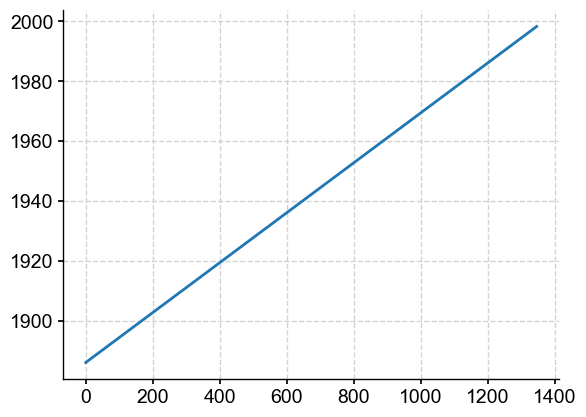

In [8]:
## just going to plot the date to check that it is linear
plt.plot(NU11_palmyra_xr.time) 

# this plots the time axis on the y-axis, vs the index (which is the position in the data)

#### We can also plot up the Sr/Ca data really easily! This way we can see what we are doing. 

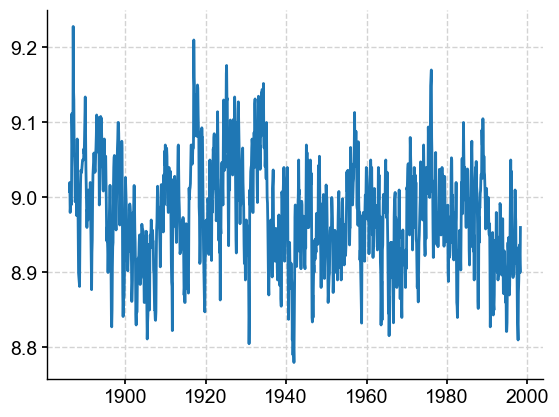

In [9]:

plt.plot(NU11_palmyra_xr.time, NU11_palmyra_xr.SrCa) 


### Now we want to upload the SST data in order to compare SST at the location with the Sr/Ca values.

I have already segmented the SST for you, and selected it from the OISST dataset (Huang et al., 2021). There are a number of different SST products we could use, however, we will use this one as the original paper says that the in-situ SST in the region best corresponds to the Reynolds SST dataset which is an older version of OISST.

- you can read about OISST here - https://www.ncei.noaa.gov/products/optimum-interpolation-sst


In [10]:
OISST_palmyra = xr.open_dataset('NU11_palmyra_OISST.nc') # this is how we open a netcdf4 file into an xarray dataset 
OISST_palmyra

# HADISST_palmyra = xr.open_dataset('NU11_palmyra_HADISST.nc') # this is how we open a netcdf4 file into an xarray dataset 
# HADISST_palmyra


<xarray.Dataset>
Dimensions:  (time: 200)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 1998-04-01
Data variables:
    sst      (time) float32 ...
Attributes:
    description:  OISSTv2

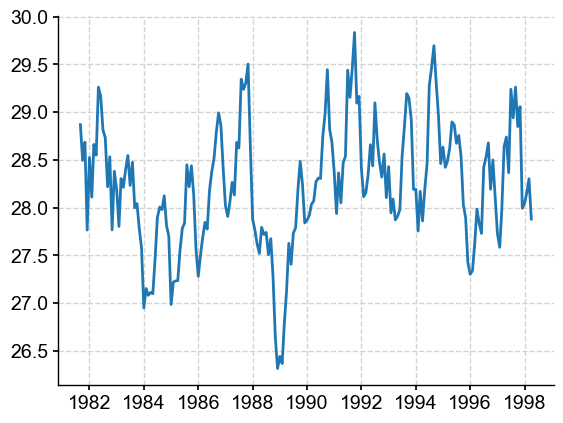

In [11]:
# we can also plot this to see what it looks like 
plt.plot(OISST_palmyra.time, OISST_palmyra.sst)
# plt.plot(HADISST_palmyra.time, HADISST_palmyra.sst)


### Correlations 

Okay now that we have the coral data and the sst in this datasheet we want to look at how well the two datasets relate to each other. We do this by testing the correlation between the two dataset. 

We will look at Sr/Ca of the coral, as this is the proxy related to SST. There are a number of ways to do this, and a number of things to think about (like autocorrelation and lag of the dataset) but we are going to ignore that for the moment. 

To look at the two datasets we need them to be the same length, at the moment the coral spans from 1882-1998 and the sst only covers the instrumental period of the coral (1981-1998). So we have to shorten the coral.


In [12]:
startyr = 1981 # Starting this on the same time frame at OISST. OISST starts at the 1/9/1981
endyr = 1998  # the end of the coral period. I have already shorted the SST for you


t1 = datetime(startyr, 9, 1)     #we can set the month and date here
t2 = datetime(endyr, 5, 1) 

# and a function in the xarray package allows us to slice. This is the .sel function, allowing slices along a coord
NU11_palmyra_short = NU11_palmyra_xr.sel(time=slice(t1, t2)) 
NU11_palmyra_short

<xarray.Dataset>
Dimensions:  (time: 200, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1981-09-15 1981-10-15 ... 1998-04-15
Data variables:
    d18O     (time) float64 -5.12 -5.1 -5.11 -5.04 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 8.917 8.943 8.957 8.978 ... 8.937 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

In [13]:
#we can just print the length of both to check they are the same, 
# and you can check that the two start at the same time youself
print ('the length of the short coral is - '+ str(len(NU11_palmyra_short.time)))
print ('the length of the SST is - '+ str(len(OISST_palmyra.time)))

the length of the short coral is - 200
the length of the SST is - 200


To test the correlations we do need to use a correlation function. The best way to do this is actually to transfer the data into a different datatype called a pyleo series. You can check out more informatino about it here if you want (https://pyleoclim-util.readthedocs.io/en/latest/index.html). 

The reason we use this is that they have a really nice function which allows us to account for the autocorrealtion of datasets (this is often the case in monthly climate data), by calculating the correlation and p-value through an n-effective number. We can talk about this more, but won't have time to go into it here! 

In [15]:

NU11_palmyra_shortpy=pyleo.Series(time=NU11_palmyra_short['time'],value=NU11_palmyra_short['SrCa'],time_name='Years CE',value_name='d18O')
OISST_py=pyleo.Series(time=OISST_palmyra['time'],value=OISST_palmyra['sst'],time_name='Years CE',value_name='SST', clean_ts=False)

class structtype():
    pass
r = structtype()
r.SST_corr =NU11_palmyra_shortpy.correlation(OISST_py, settings={'method':'ttest'})

print ('---------------------------------------------')
print ('The corre between the Palmyra coral Sr/Ca and OISST')
print (str(r.SST_corr))


---------------------------------------------
The corre between the Palmyra coral Sr/Ca and OISST
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     -0.75399  < 1e-5     True



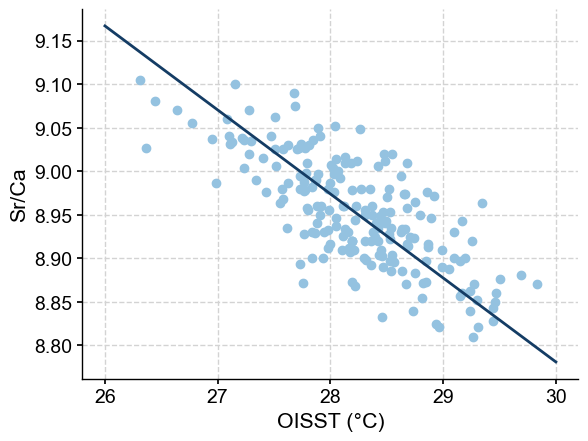

bimonthly ERSST and MAU1 WLS
---------------------------
The slope between ERSST and SrCa -0.09646042143744483
The slope error between ERSST and SrCa 0.004988799066966241
The intercept between ERSST and SrCa 11.674835763336684
The intercept error between ERSST and SrCa 0.1408274803392929
The correlation between ERSST and SrCa -0.7351157152649119


In [16]:
results = regress2(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values, _method_type_2="reduced major axis")

x = np.linspace(26,30,100)
y = (results['slope'])*x+results['intercept']

plt.scatter(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values,c= '#94c2e0')
plt.plot(x, y, '#143c64', label='y=2x+1')


plt.xlabel('OISST (°C)')
# naming the y axis
plt.ylabel('Sr/Ca')

# plt.savefig('Scatter_OISST_d18O.pdf',dpi=600, bbox_inches='tight')
plt.show()


print ('bimonthly ERSST and MAU1 WLS')
print ('---------------------------')

print ("The slope between ERSST and SrCa " + str(results['slope']))
print ("The slope error between ERSST and SrCa " + str(results['std_slope']))
print ("The intercept between ERSST and SrCa " + str(results['intercept']))
print ("The intercept error between ERSST and SrCa " + str(results['std_intercept']))
print ("The correlation between ERSST and SrCa " + str(results['r']))

# Q1. What do these values mean?

Have a go at thinking about what these values mean? You can write this in the box below..

- some hints, what does the correlation mean? what does the slope mean etc. 
- what is the relationship between SST and Sr/Ca in the coral at Palmyra



## Climate time series are made up generally of the seasonal data, and a trend component. 

We know that Sr/Ca is related to SST and from this we can split the time series up into a component which is the trend, and a second which is the seasonality. The two additions of these componenets (seasonality and trend) is called additive seasonality. 

We can pull these out and say what component is related to each it allows us to do a number of things; 

- look at what sort of trend is in our data, i.e. how much the temperature has increased?
- look at what component of the data is related to the seasonality

In [17]:
# first lets go back to the initial dataframe that we were using as we need to reset the index.
NU11_palmyra_ar = NU11_palmyra_xr.to_array()

NU11_palmyra = NU11_palmyra.set_index('time') # this will just set the index to the datetime component
NU11_palmyra

,Date,d18O,SrCa,SrCa_SST,d18Osw
time,,,,,
1886-02-15,1886.13,-4.79,9.0082,27.843056,0.816194
1886-03-15,1886.21,-4.89,9.0200,27.708680,0.687975
1886-04-15,1886.29,-4.81,8.9800,28.164193,0.863632
1886-05-15,1886.38,-4.84,8.9891,28.060564,0.811870
1886-06-15,1886.46,-4.85,8.9967,27.974016,0.783695
...,...,...,...,...,...
1997-12-15,1997.96,-5.48,8.9167,28.885044,0.345011
1998-01-15,1998.04,-5.43,8.9367,28.657287,0.347182
1998-02-15,1998.13,-5.49,8.9120,28.938566,0.346251



We could do this manually, however this would take a while but basically we can split our data into the following; 

            Y[t] = T[t] + S[t] + e[t]

    - Y[t]: Our time-series function
    - T[t]: Trend (general tendency to move up or down)
    - S[t]: Seasonality (cyclic pattern occurring at regular intervals)
    - e[t]: Residual (random noise in the data that isn’t accounted for in the trend or seasonality

There is a handing function ins the statsmodels package that we downloaded earlier which will help us look at the data. It requires data in a pandas format (which is what we have above), and it to be linked to a datetime object (which we just checked).

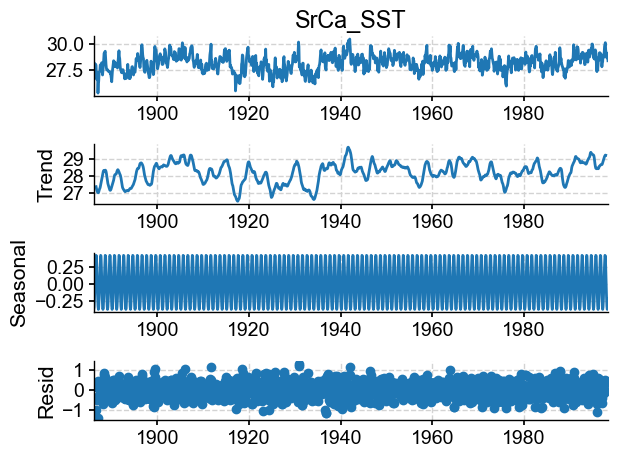

In [18]:
#the below does it for us! We input into the seasonal_decompose(data, model = "additive", period = 'the required')
decompose_result_mult = seasonal_decompose(NU11_palmyra.SrCa_SST, model="additive", period =12)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

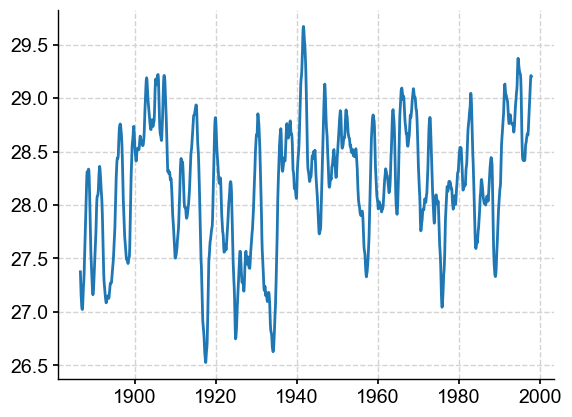

In [19]:
plt.plot(trend)

# So now we know that the Sr/Ca relates well to SST; 

- we can explore how well the SST (the Sr/Ca from the Palmyra location) relates to ENSO, so that this coral can then be used to reconstruct ENSO like is explained in the paper. 

To do this we need to look at the interannual variability of SST (Sr/Ca). ENSO is a climate phenomena which operates on interannual timescales (2-7yr), and therefore the best way to compare the ENSO indices (NINO3.4, SOI etc.) to SST at a location is to extract the interannual variability. 

To do this we can use something called a bandpass filter. A bandpass filter is basically used to filter a particular range of frequencies (for us the frequencies between 2-7 years), there are lots of different filters that you can use for this  but today we are going to use a butterworth filter. 

    - read more about high, low and bandpass filters here;
        - https://www.rfpage.com/low-pass-high-pass-and-band-pass-filters-simple-explanation/
        
#### What is cool is that the pyleoclim package makes this filtering process really easy! 


### First we have to make a pyleo series...

This is just making a pyleo series, where we use the NU11_palmyra xarray dataset of Sr/Ca.

<xarray.Dataset>
Dimensions:  (time: 1347, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1886-02-15 1886-03-15 ... 1998-04-15
Data variables:
    d18O     (time) float64 -4.79 -4.89 -4.81 -4.84 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 9.008 9.02 8.98 8.989 8.997 ... 8.937 8.912 8.9 8.96
    SST      (time) float64 27.83 27.69 28.15 28.04 ... 28.64 28.92 29.06 28.38
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

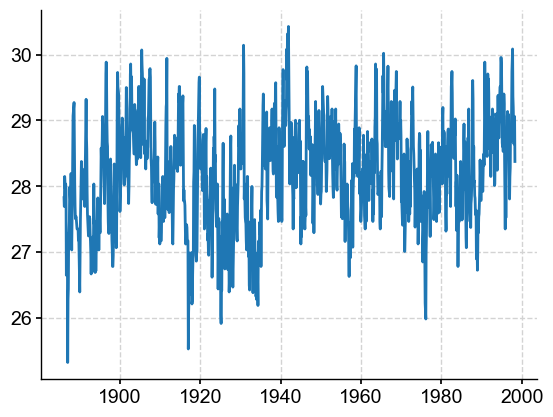

In [20]:
NU11_palmyra_xr['SST'] = 130.43 - 11.39 * NU11_palmyra_xr.SrCa
plt.plot(NU11_palmyra_xr.time, NU11_palmyra_xr.SST)
NU11_palmyra_xr

In [21]:

#Calculating the anomalies of the two SST datasets

climatology_NU11 = NU11_palmyra_xr.groupby('time.month').mean('time')

anomalies_NU11 = NU11_palmyra_xr.groupby('time.month') - climatology_NU11
anomalies_NU11

<xarray.Dataset>
Dimensions:  (Date: 1347, time: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1886-02-15 1886-03-15 ... 1998-04-15
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 6 7 8 9 10 11 12 1 2 3 4
Data variables:
    d18O     (time) float64 -0.01699 -0.06903 0.03743 ... -0.717 -0.649 -0.5626
    SrCa     (time) float64 -0.001616 0.01323 -0.01615 ... -0.1068 -0.03615
    SST      (time) float64 0.01841 -0.1507 0.184 ... 1.114 1.216 0.4118

In [26]:

NU11_palmyra_anom_py=pyleo.Series(time=anomalies_NU11['Date'],value=anomalies_NU11['SST'],time_name='Years CE',value_name='d18O')
# NU11_palmyra_py.__dict__

NU11_palmyra_1Y = NU11_palmyra_anom_py.bin(bin_size=0.083333333, start = 1886.083333333)
# NU11_palmyra_py.__dict__

/Users/jessicahargreaves/opt/anaconda3/envs/spp2299/lib/python3.10/site-packages/pyleoclim/utils/tsutils.py:140: UserWarning: The bin_size has been set, the series may not be evenly_spaced
  warnings.warn('The bin_size has been set, the series may not be evenly_spaced')


In [27]:
NU11_palmyra_filter_but = NU11_palmyra_1Y.filter(method='butterworth',cutoff_scale=[2,7])
NU11_palmyra_filter_but.__dict__

{'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},),
 'time': array([1886.125     , 1886.20833333, 1886.29166667, ..., 1998.12499955,
        1998.20833288, 1998.29166622]),
 'value': array([ 0.00710383, -0.1622198 , -0.32791284, ...,  0.20771034,
         0.10278478, -0.00655962]),
 'time_name': 'Years CE',
 'time_unit': None,
 'value_name': 'd18O',
 'value_unit': None,
 'label': None,
 'mean': -1.5297505075755683e-15}

Text(0.5, 1.0, 'High-pass filter <11 year')

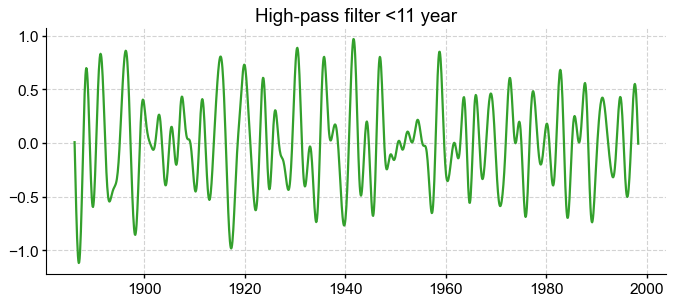

In [28]:
# fig, (ax1, ax2) = plt.subplots(figsize=[20, 5])

fig, (ax1) = plt.subplots(1, figsize=(10, 4), dpi = 80, sharex=True)

# inter_Nasa.plot(ax=ax)
# inter_Timor.plot(ax=ax)
# inter_christmas.plot(ax=ax)


ax1.plot(NU11_palmyra_filter_but.time,NU11_palmyra_filter_but.value,'#33a02c')
# ax1.plot(Nino3_4.time,Nino3_4.Nino34r)
ax1.set_title('High-pass filter <11 year')


In [29]:
Nino3_4 = xr.open_dataset('Nino34.nc') # this is how we open a netcdf4 file into an xarray dataset 
Nino3_4_py=pyleo.Series(time=Nino3_4['Date'],value=Nino3_4['Nino34r'],time_name='Years CE',value_name='d18O')
Nino3_4_py.__dict__

Nino3_4_filter_but = Nino3_4_py.filter(method='butterworth',cutoff_scale=[2,7])
Nino3_4_filter_but.__dict__

{'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},),
 'time': array([1886.125     , 1886.20833333, 1886.29166667, ..., 1998.125     ,
        1998.20833333, 1998.29166667]),
 'value': array([ 0.0804409 , -0.17139214, -0.4169751 , ...,  0.57472006,
         0.32486834,  0.0630884 ]),
 'time_name': 'Years CE',
 'time_unit': None,
 'value_name': 'd18O',
 'value_unit': None,
 'label': None,
 'mean': 0.07452952650707495}

Text(0.5, 1.0, 'Band-pass filter, 2-7 year')

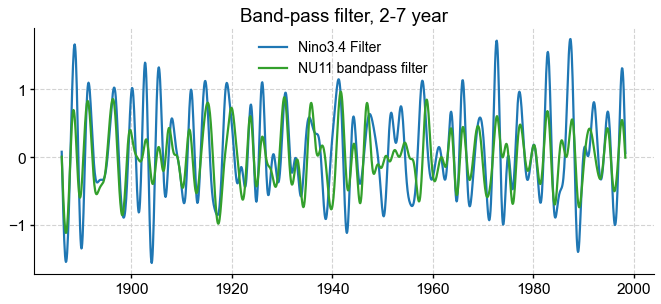

In [30]:
# fig, (ax1, ax2) = plt.subplots(figsize=[20, 5])

fig, (ax1) = plt.subplots(1, figsize=(10, 4), dpi = 80, sharex=True)

# inter_Nasa.plot(ax=ax)
# inter_Timor.plot(ax=ax)
# inter_christmas.plot(ax=ax)
ax1.plot(Nino3_4_filter_but.time,Nino3_4_filter_but.value, label = 'Nino3.4 Filter')

ax1.plot(NU11_palmyra_filter_but.time,NU11_palmyra_filter_but.value,'#33a02c',label='NU11 bandpass filter')

ax1.legend()
ax1.set_title('Band-pass filter, 2-7 year')


In [ ]:

class structtype():
    pass
r = structtype()
r.SST_corr =NU11_palmyra_filter_but.correlation(Nino3_4_filter_but, settings={'method':'ttest'})

print ('---------------------------------------------')
print ('The corre between the Palmyra coral Sr/Ca and OISST')
print (str(r.SST_corr))